<a href="https://colab.research.google.com/github/paulorfbr/tensor_flow_course_deep_learning/blob/resnet/TF2_Resnet_fruits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
print(tf.__version__)

2.13.0


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 16
batch_size = 32

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/fruits-360.zip

--2023-10-23 09:52:23--  https://lazyprogrammer.me/course_files/fruits-360.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M  44.7MB/s    in 7.6s    

2023-10-23 09:52:31 (23.8 MB/s) - ‘fruits-360.zip’ saved [190820824/190820824]



In [ ]:
!unzip -nq fruits-360.zip

In [ ]:
train_path = 'fruits-360/Training'
valid_path = 'fruits-360/Validation'

In [ ]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

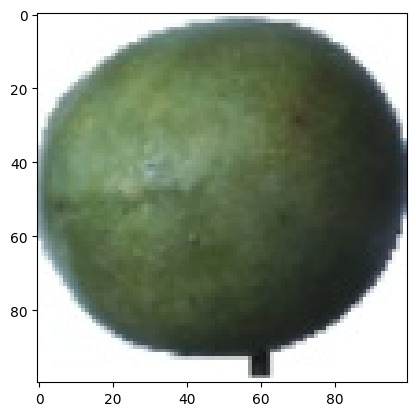

In [ ]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()


In [ ]:
# add preprocessing layer to the front of VGG
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in res.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=res.input, outputs=prediction)


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 106, 106, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 50, 50, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 50, 50, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [ ]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

Found 9673 images belonging to 60 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Carambula': 16, 'Cherry': 17, 'Clementine': 18, 'Cocos': 19, 'Dates': 20, 'Granadilla': 21, 'Grape Pink': 22, 'Grape White': 23, 'Grape White 2': 24, 'Grapefruit Pink': 25, 'Grapefruit White': 26, 'Guava': 27, 'Huckleberry': 28, 'Kaki': 29, 'Kiwi': 30, 'Kumquats': 31, 'Lemon': 32, 'Lemon Meyer': 33, 'Limes': 34, 'Litchi': 35, 'Mandarine': 36, 'Mango': 37, 'Maracuja': 38, 'Nectarine': 39, 'Orange': 40, 'Papaya': 41, 'Passion Fruit': 42, 'Peach': 43, 'Peach Flat': 44, 'Pear': 45, 'Pear Abate': 46, 'Pear Monster': 47, 'Pear Williams': 48, 'Pepino': 49, 'Pineapple': 50, 'Pitahaya Red': 51, 'Plum': 52, 'Pomegranate': 53, 'Quince': 54, 'Ra

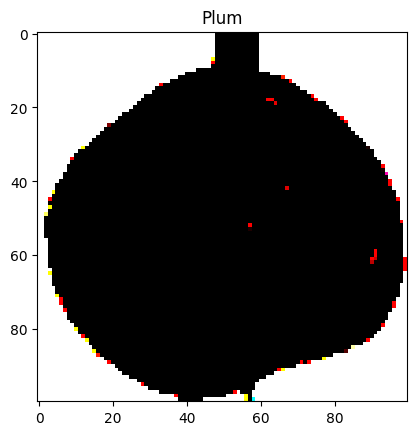

In [ ]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [ ]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


In [ ]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/16
898/898 [==============================] - 166s 172ms/step - loss: 1.1786 - accuracy: 0.9049 - val_loss: 0.8745 - val_accuracy: 0.9250
Epoch 2/16
898/898 [==============================] - 139s 155ms/step - loss: 0.1987 - accuracy: 0.9800 - val_loss: 0.4581 - val_accuracy: 0.9626
Epoch 3/16
898/898 [==============================] - 138s 153ms/step - loss: 0.1211 - accuracy: 0.9876 - val_loss: 0.7096 - val_accuracy: 0.9546
Epoch 4/16
898/898 [==============================] - 138s 154ms/step - loss: 0.0930 - accuracy: 0.9910 - val_loss: 0.4645 - val_accuracy: 0.9654
Epoch 5/16
898/898 [==============================] - 134s 149ms/step - loss: 0.0659 - accuracy: 0.9933 - val_loss: 0.6397 - val_accuracy: 0.9590
Epoch 6/16
898/898 [==============================] - 134s 149ms/step - loss: 0.0610 - accuracy: 0.9944 - val_loss: 0.3573 - val_accuracy: 0.9750
Epoch 7/16
898/898 [==============================] - 133s 149ms/step - loss: 0.0402 - accuracy: 0.9957 - val_loss: 0.3051 -

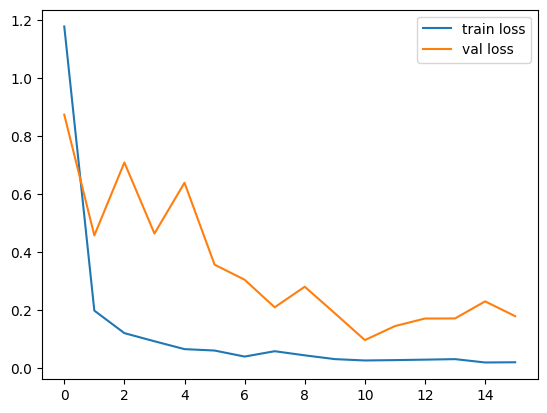

In [ ]:
# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

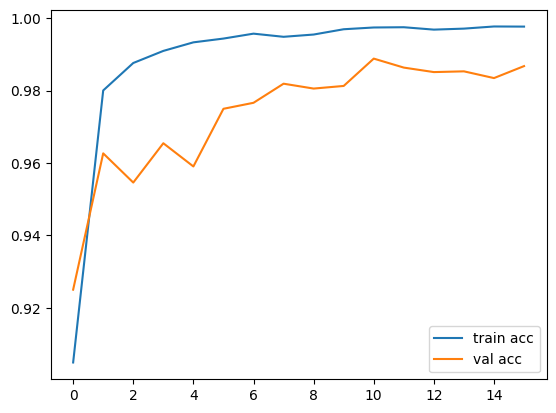

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


def y2indicator(Y):
  K = len(set(Y))
  N = len(Y)
  I = np.empty((N, K))
  I[np.arange(N), Y] = 1
  return I

In [ ]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 28736
Found 28736 images belonging to 60 classes.
2/2 [==============================] - 0s 38ms/step
50
2/2 [==============================] - 0s 35ms/step
100
2/2 [==============================] - 0s 42ms/step
150
2/2 [==============================] - 0s 38ms/step
200
2/2 [==============================] - 0s 38ms/step
250
2/2 [==============================] - 0s 38ms/step
300
2/2 [==============================] - 0s 37ms/step
350
2/2 [==============================] - 0s 38ms/step
400
2/2 [==============================] - 0s 38ms/step
[[491   0   0 ...   0   0   0]
 [  0 492   0 ...   0   0   0]
 [  0   0 491 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 490   0]
 [  0   0   0 ...   0   0 483]]
Generating confusion matrix 9673
Found 9673 images belonging to 60 classes.
2/2 [==============================] - 0s 38ms/step
50
2/2 [==============================] - 0s 38ms/step
100
2/2 [==============================] - 0s 38

In [ ]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

Confusion matrix, without normalization
[[491   0   0 ...   0   0   0]
 [  0 492   0 ...   0   0   0]
 [  0   0 491 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 490   0]
 [  0   0   0 ...   0   0 483]]


In [ ]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

Confusion matrix, without normalization
[[162   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 163 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 158]]
